In [1]:
from torchvision import transforms
from skimage import io, transform
import numpy as np
import pandas as pd
import cv2
import torch

import torch.nn.functional as F
import torch.nn as nn


import os
import shutil
import sys
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision.models as models

In [2]:
class coviddata(Dataset):
    def __init__(self, csvpathtrain,imgfolder,input_shape1):
        self.traindata=pd.read_csv(csvpathtrain)
        self.folder_path=imgfolder
        self.input_shape=input_shape1
 
    def __getitem__(self, indx):
        if torch.is_tensor(indx):
            indx = indx.tolist()
        img1path=self.traindata.filename[indx]
        full1=self.folder_path+"/"+img1path
        img=io.imread(full1)

        s1=np.shape(img)
        if np.size(s1)>=3:
            if s1[2]>3:
                img=img[:,:,0:3]
                img=img.astype(float)
                img=np.sum(img,2)/3
            else:
                img=img.astype(float)
                img=np.sum(img,2)/3

        label_name=self.traindata.label[indx]
        if label_name=="normal":
          n1=1
          n2=0
          n3=0
        elif label_name=="pneumonia":
          n1=0
          n2=1
          n3=0
        elif label_name=="COVID-19":
          n1=0
          n2=0
          n3=1
        img=cv2.resize(img,self.input_shape)
        s1=np.shape(img)

        img=np.asarray([img,img,img])
        img=torch.from_numpy(img).float()
        torch1=np.array([n1,n2,n3]).argmax()
        label=torch.from_numpy(np.array(torch1)).long()

        return ( img, label)

    def __len__(self):
            return len(self.traindata)



In [3]:
class Net1(nn.Module):
    def __init__(self,out_1):
        super(Net1,self).__init__()
        self.resnet1=models.resnet18(pretrained=False);
        num_fea=self.resnet1.fc.in_features
        self.features=nn.Sequential(*list(self.resnet1.children())[:-1])
       #non linear projection head
        self.layer1=nn.Linear(num_fea,num_fea)
        self.layer2=nn.Linear(num_fea,out_1)

    def forward(self,x):
        p1=self.features(x)
        p1=p1.squeeze()
        x=self.layer1(p1)
        x=F.relu(x)
        x=self.layer2(x)
        return p1,x

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class NonLinearClassify(nn.Module):
    def __init__(self,in1):
        super(NonLinearClassify,self).__init__()
        self.layer1=nn.Linear(in1,2*in1)
        self.layer2=nn.Linear(2*in1,in1)
        self.layer3=nn.Linear(in1,3)

    def forward(self,x):
        p1=self.layer1(x)
        p1=F.relu(p1)
        p1=self.layer2(p1)
        p1=F.relu(p1)
        p1=self.layer3(p1)
        return p1


In [5]:
class Finetuner3(object):
    def __init__(self,traindataset,validdataset,batch_size,num_epochs1,usemodel,trainfeatures,out_1):

        self.traindataset=traindataset
        self.validdataset=validdataset
        self.batch_size1=batch_size
        self.num_epochs=num_epochs1
        self.trainfea=trainfeatures
        self.usemodel=usemodel
        self.out_1=out_1
        self.device='cuda' if torch.cuda.is_available() else 'cpu'
        classweights=[0.1,0.1,1000]
        classweights=torch.FloatTensor(classweights).to(self.device)
        self.criterion=nn.CrossEntropyLoss(weight=classweights)
        print("Running on device "+str(self.device))

    def _step(self,encoder1,classi1,x):
        rep1,proj1=encoder1(x)

        rep1=rep1.squeeze()
        rep1=classi1(rep1)

        return rep1

    def train(self):
        print("\n Batch Size selected="+str(self.batch_size1))
        print("number of epochs set="+str(self.num_epochs))

        trainLoader=DataLoader(self.traindataset,batch_size=self.batch_size1,shuffle=True,num_workers=4,drop_last=True)
        validLoader=DataLoader(self.validdataset,batch_size=4,shuffle=True,num_workers=4,drop_last=True)

        model=Net1(out_1=self.out_1).to(self.device)

        #COUNTS AND PRINTS THE TOTAL NUMBER OF THE WEIGHTS OF THE NETWORK
        pytorch_total_params = sum(p.numel() for p in model.parameters())
        print("Number of parameters: ", pytorch_total_params)
        
        if self.usemodel:
            print("using pre trained")
            try:
                state_dict1=torch.load("./classifier/modelUse.pth")
                model.load_state_dict(state_dict1)
                print("Loaded pre trained successfully")
            except FileNotFoundError:
                print("Pre trained not found")
        if self.trainfea==False:
            for params in model.parameters():
                params.requires_grad=False
        model.train()
        num_in=self.out_1;

        resnet1=models.resnet18(pretrained=False);
        num_fea=resnet1.fc.in_features

        classif1=NonLinearClassify(num_fea).to(self.device)

        if self.trainfea==True:
            params=list(model.parameters())+list(classif1.parameters())
        else:
            params=list(classif1.parameters())
        optimizer=torch.optim.Adam(params,3e-4,weight_decay=10e-6)

        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(trainLoader), eta_min=0,last_epoch=-1)

        validarrayloss=np.array(0)
        lossarray=np.array(0)
        vlb=np.inf
        for n1 in range(self.num_epochs):
            print(" Starting epoch " +str(n1) )

            for (image1,label1) in trainLoader:
                optimizer.zero_grad()
                inp1=image1
                out=label1
                inp1=inp1.to(self.device)
                out=out.to(self.device)
                pred=self._step(model,classif1,inp1)
                #pred=torch.argmax(pred)
                loss=self.criterion(pred,out)

                loss.backward()
                optimizer.step()
            if n1>=10:
                scheduler.step()
            print("epoch num"+str(n1))

            if n1%5 == 0:
                validationloss1=self._validate(model,classif1,validLoader)
                print("Validation loss="+str(validationloss1)+"epoch "+str(n1))

                validarrayloss=np.append(validarrayloss,validationloss1)
                pd.DataFrame(validarrayloss).to_csv("./validate/validfile2.csv")

                lossarray=np.append(lossarray,loss.item())

                pd.DataFrame(lossarray).to_csv("./arrayfile2.csv")



                if validationloss1< vlb:
                    vlb=validationloss1

                    torch.save(model.state_dict(),"./validate/modelR1.pth")
                    torch.save(classif1.state_dict(),"./validate/classifR1.pth")

                    print("Saving weights after epoch"+str(n1))
                print("\n End of epoch " +str(n1) )

            if n1 % 10 == 0:
                torch.save(model.state_dict(),"./modelR"+str(n1)+".pth")
                torch.save(classif1.state_dict(),"./classifR"+str(n1)+".pth")

        torch.save(model.state_dict(),"./modelRFull.pth")
        torch.save(classif1.state_dict(),"./classifRFull.pth")
        print("Training run completed")
        pd.DataFrame(validarrayloss).to_csv("./validfile2.csv")

    def _validate(self, model,classi1, valid_loader):
        print("In validate")
        # validation steps
        with torch.no_grad():
            model.eval()
            classi1.eval()
            #counter=0
            valid_loss = 0.0
            for counter, (image1,label) in enumerate(valid_loader):
                #print("Infor")
                inp1=image1
                inp1 = inp1.to(self.device)
                out1=label
                out1=out1.to(self.device)
                #print("validating-"+str(counter))
                pred = self._step(model,classi1,inp1)
                loss=self.criterion(pred,out1)
                #print("inside "+str(loss.item()))
                valid_loss += loss.item()
            counter1=1
            valid_loss /= counter1
        model.train()
        classi1.train()
        return valid_loss

In [6]:
traindataset1=coviddata(csvpathtrain="./files/train.csv",imgfolder="./data1/train",input_shape1=(224,224))
validationdataset1=coviddata(csvpathtrain="./files/covidXtest.csv",imgfolder="./data1/test",input_shape1=(224,224))

In [7]:
net1=Finetuner3(traindataset=traindataset1,validdataset=validationdataset1,batch_size=16,num_epochs1=100,out_1=256,usemodel=True,trainfeatures=True) #from 16 to 2

Running on device cuda


In [8]:
torch.__version__

'1.8.1+cu102'

In [13]:
net1.train()


 Batch Size selected=16
number of epochs set=100
Number of parameters:  12083496
using pre trained
Loaded pre trained successfully
 Starting epoch 0
epoch num0
In validate
Validation loss=31.90844391239807epoch 0
Saving weights after epoch0

 End of epoch 0
 Starting epoch 1
epoch num1
 Starting epoch 2
epoch num2
 Starting epoch 3
epoch num3
 Starting epoch 4
epoch num4
 Starting epoch 5
epoch num5
In validate
Validation loss=38.42088803953084epoch 5

 End of epoch 5
 Starting epoch 6
epoch num6
 Starting epoch 7
epoch num7
 Starting epoch 8
epoch num8
 Starting epoch 9
epoch num9
 Starting epoch 10
epoch num10
In validate
Validation loss=52.5582621673384epoch 10

 End of epoch 10
 Starting epoch 11
epoch num11
 Starting epoch 12
epoch num12
 Starting epoch 13
epoch num13
 Starting epoch 14
epoch num14
 Starting epoch 15
epoch num15
In validate
Validation loss=62.46839253187261epoch 15

 End of epoch 15
 Starting epoch 16
epoch num16
 Starting epoch 17
epoch num17
 Starting epoch 18


In [11]:
class CovidDatasetTest(Dataset):
    def __init__(self,dataframe,im_folder,input_shape=(224,224)):
        self.df = dataframe
        self.im_folder = im_folder
        self.input_shape = input_shape
        self.file_id = np.unique(self.df.filename.values)
        self.label_dict = {'normal': 0, 'pneumonia': 1, 'COVID-19': 2}
    
    def __getitem__(self,index):
        filename = self.file_id[index]
        path = os.path.join(self.im_folder,filename)
        img = io.imread(path)
        
        s1 = np.shape(img)
        if np.size(s1)>=3:
            if s1[2]>3:
                img=img[:,:,0:3]
                img=img.astype(float)
                img=np.sum(img,2)/3
            else:
                img=img.astype(float)
                img=np.sum(img,2)/3
                
        target = [self.label_dict[self.df.iloc[index]["label"]]]
        img = cv2.resize(img,self.input_shape)
        img = np.asarray([img,img,img])
        
        return torch.FloatTensor(img), torch.FloatTensor(target)
    
    def __len__(self):
        return len(self.file_id)

In [13]:
path1 = './classifRFull.pth'
path2 = './modelRFull.pth'

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
model1 = Net1(out_1=256)
model1.load_state_dict(torch.load(path2, map_location=torch.device(device)))
model1.to(device)
model1.eval()

Net1(
  (resnet1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [17]:
model2 = NonLinearClassify(in1=512)
model2.load_state_dict(torch.load(path1, map_location=torch.device(device)))
model2.to(device)
model2.eval()

NonLinearClassify(
  (layer1): Linear(in_features=512, out_features=1024, bias=True)
  (layer2): Linear(in_features=1024, out_features=512, bias=True)
  (layer3): Linear(in_features=512, out_features=3, bias=True)
)

In [18]:
final_conv = model1.features[7][1]._modules.get('conv2')
print(final_conv)
fc_params = list(model1._modules.get('layer2').parameters())

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [19]:
import matplotlib.pyplot as plt
import torch.nn.functional as F


class SaveFeatures():
    """ Extract pretrained activations"""
    features = None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self):
        self.hook.remove()


def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv[0,:, :, ].reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return cam_img


def plotGradCAM(model, final_conv, fc_params, train_loader, 
                row=1, col=8, img_size=224, device='cpu', original=False):
    for param in model.parameters():
        param.requires_grad = False
    for param in model1.parameters():
        param.requires_grad = False
        
    model.to(device)
    model.eval()
    # save activated_features from conv
    activated_features = SaveFeatures(final_conv)
    # save weight from fc
    weight = np.squeeze(fc_params[0].cpu().data.numpy())
    # original images
    if original:
        fig = plt.figure(figsize=(20, 15))
        for i, (img, target) in enumerate(train_loader):
            org_img = img
            x,y = model1(img.to(device))
            output = model(x)
            pred_idx = output.to('cpu').numpy().argmax()
            cur_images = org_img.numpy().transpose((0, 2, 3, 1))
            ax = fig.add_subplot(row, col, i+1, xticks=[], yticks=[])
            plt.imshow(cv2.cvtColor(cur_images[0], cv2.COLOR_BGR2RGB).astype('uint8'))
            ax.set_title('Label:%d, Predict:%d' % (target.item(), pred_idx), fontsize=14)
            if i == row*col-1:
                break
        plt.show()
    # heatmap images
    fig = plt.figure(figsize=(20, 15))
    for i, (img, target) in enumerate(train_loader):
        x,y = model1(img.to(device))
        output = model(x)
        pred_idx = output.to('cpu').numpy().argmax()
        cur_images = img.cpu().numpy().transpose((0, 2, 3, 1))
        heatmap = getCAM(activated_features.features, weight, pred_idx)
        ax = fig.add_subplot(row, col, i+1, xticks=[], yticks=[])
        plt.imshow(cv2.cvtColor(cur_images[0], cv2.COLOR_BGR2RGB).astype('uint8'))
        plt.imshow(cv2.resize(heatmap, (img_size, img_size), interpolation=cv2.INTER_LINEAR), alpha=0.4, cmap='jet')
        ax.set_title('Label:%d, Predict:%d' % (target.item(), pred_idx), fontsize=14)
        if i == row*col-1:
            break
    plt.show()

In [20]:
testdataset=coviddata(csvpathtrain="./files/covidXtest.csv",imgfolder="./data/test",input_shape1=(224,224))
testdata_loader=DataLoader(testdataset,batch_size=1,shuffle=True,num_workers=2,drop_last=True)

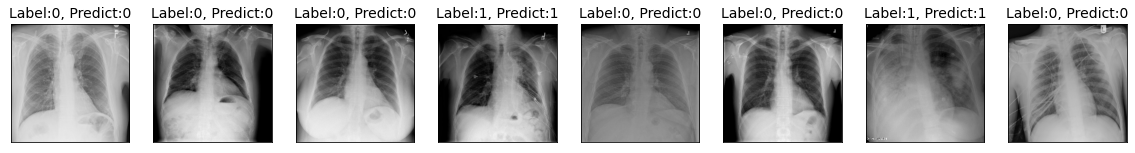

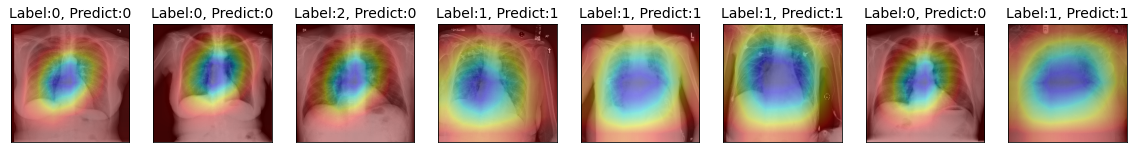

In [23]:
label = 0
plotGradCAM(model2, final_conv, fc_params, testdata_loader, img_size=224, device='cuda', original=True)

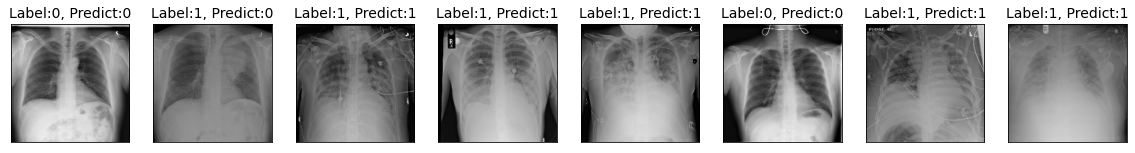

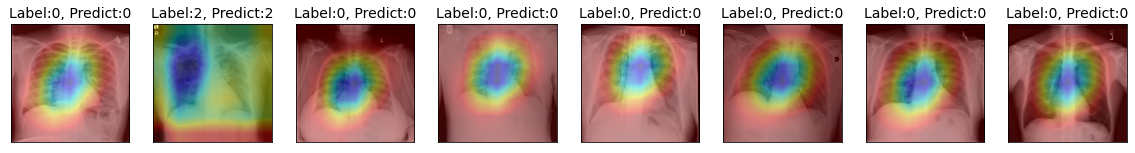

In [46]:
label = 0
plotGradCAM(model2, final_conv, fc_params, testdata_loader, img_size=224, device='cuda', original=True)